In [1]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("008 Bajas").getOrCreate()

In [2]:
datos=spark.read.csv("clientes.csv",header=True,inferSchema=True)

In [3]:
datos.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [4]:
datos.groupBy("Company").count().orderBy("count",ascending=False).show()

+--------------+-----+
|       Company|count|
+--------------+-----+
|Anderson Group|    4|
|    Wilson PLC|    3|
|  Williams PLC|    3|
|Perry and Sons|    2|
|     Gates Ltd|    2|
|    Walker Ltd|    2|
|   Davis Group|    2|
|      Webb PLC|    2|
|   Smith Group|    2|
|Smith and Sons|    2|
|     Ortiz Ltd|    2|
|     Smith Inc|    2|
|  Williams LLC|    2|
|      Rice PLC|    2|
|      Soto PLC|    2|
|    Nelson LLC|    2|
|      King LLC|    2|
|     Evans LLC|    2|
|     Jones LLC|    2|
|Davis and Sons|    2|
+--------------+-----+
only showing top 20 rows



In [5]:
from pyspark.ml.feature import VectorAssembler

In [6]:
constructor=VectorAssembler(inputCols=['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites'],outputCol="features")

In [7]:
datosFinales=constructor.transform(datos)

In [8]:
datosFinales.first()

Row(Names='Cameron Williams', Age=42.0, Total_Purchase=11066.8, Account_Manager=0, Years=7.22, Num_Sites=8.0, Onboard_date=datetime.datetime(2013, 8, 30, 7, 0, 40), Location='10265 Elizabeth Mission Barkerburgh, AK 89518', Company='Harvey LLC', Churn=1, features=DenseVector([42.0, 11066.8, 0.0, 7.22, 8.0]))

In [9]:
datosEntrena,datosEvalua=datosFinales.randomSplit([0.7,0.3])

In [10]:
from pyspark.ml.classification import LogisticRegression

In [11]:
rLogi=LogisticRegression(labelCol="Churn")

In [12]:
modelo=rLogi.fit(datosEntrena)

In [13]:
modelo.coefficients

DenseVector([0.0719, 0.0, 0.5686, 0.6275, 1.3808])

In [14]:
modelo.summary.areaUnderROC

0.9249122746065386

In [15]:
evalua=modelo.evaluate(datosEvalua)

In [16]:
evalua.areaUnderROC

0.8685278630978495

In [43]:
evalua.predictions.select("rawPrediction","probability","prediction","Churn").show()

+--------------------+--------------------+----------+-----+
|       rawPrediction|         probability|prediction|Churn|
+--------------------+--------------------+----------+-----+
|[5.51013470743486...|[0.99597073825056...|       0.0|    0|
|[2.30992979587431...|[0.90969608825614...|       0.0|    0|
|[5.65700850106769...|[0.99651920779269...|       0.0|    0|
|[2.38367741324981...|[0.91557412625026...|       0.0|    0|
|[6.85215592046465...|[0.99894394238560...|       0.0|    1|
|[-0.5525698375086...|[0.36526839282409...|       1.0|    0|
|[6.39118399932486...|[0.99832653485690...|       0.0|    0|
|[3.32592447096663...|[0.96530754329446...|       0.0|    0|
|[4.16190771178506...|[0.98466113437797...|       0.0|    0|
|[2.02236147474328...|[0.88312496995541...|       0.0|    0|
|[4.28754860006006...|[0.98644762735910...|       0.0|    0|
|[4.97199175155650...|[0.99311835245416...|       0.0|    0|
|[9.31138637375423...|[0.99990961902432...|       0.0|    0|
|[2.31135580939127...|[0

In [17]:
nuevoModelo=rLogi.fit(datosFinales)

In [19]:
nuevoModelo.summary.areaUnderROC

0.9082400000000004

In [21]:
nuevoModelo.summary.roc.show()

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|0.001333333333333...|0.05333333333333334|
|0.002666666666666...|0.10666666666666667|
|               0.004|               0.16|
|               0.004|               0.22|
|0.006666666666666667|0.26666666666666666|
|0.010666666666666666|0.30666666666666664|
|0.014666666666666666| 0.3466666666666667|
|0.017333333333333333| 0.3933333333333333|
|               0.024|               0.42|
| 0.02666666666666667| 0.4666666666666667|
|0.030666666666666665| 0.5066666666666667|
|               0.036|               0.54|
| 0.03866666666666667| 0.5866666666666667|
|               0.044|               0.62|
|               0.048|               0.66|
| 0.05733333333333333| 0.6733333333333333|
| 0.06533333333333333| 0.6933333333333334|
| 0.07466666666666667| 0.7066666666666667|
|               0.084|               0.72|
+----------

In [22]:
import matplotlib.pyplot as grafica

In [28]:
x=nuevoModelo.summary.roc.select("FPR").collect()
y=nuevoModelo.summary.roc.select("TPR").collect()

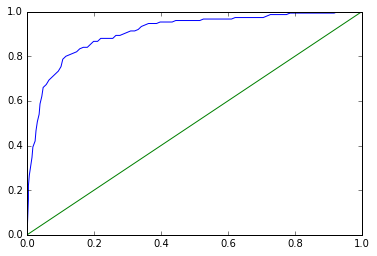

In [31]:
grafica.plot(x,y)
grafica.plot([0,1],[0,1])
grafica.show()

Predicción con datos nuevos

In [32]:
nuevosDatos=spark.read.csv("nuevos_clientes.csv",header=True,inferSchema=True)

In [33]:
nuevosDatos.show()

+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+
|         Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|         Company|
+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+
| Andrew Mccall|37.0|       9935.53|              1| 7.71|      8.0|2011-08-29 18:37:54|38612 Johnny Stra...|        King Ltd|
|Michele Wright|23.0|       7526.94|              1| 9.28|     15.0|2013-07-22 18:19:54|21083 Nicole Junc...|   Cannon-Benson|
|  Jeremy Chang|65.0|         100.0|              1|  1.0|     15.0|2006-12-11 07:48:13|085 Austin Views ...|Barron-Robertson|
|Megan Ferguson|32.0|        6487.5|              0|  9.4|     14.0|2016-10-28 05:32:13|922 Wright Branch...|   Sexton-Golden|
|  Taylor Young|32.0|      13147.71|              1| 10.0|      8.0|2012-03-20 00:36:46|Unit 0789 Box 073...|  

In [44]:
nuevos=constructor.transform(nuevosDatos)

In [45]:
nuevos.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- features: vector (nullable = true)



In [46]:
resultado=nuevoModelo.transform(nuevos)

In [51]:
resultado.select("Names","prediction").where("prediction=1").show()

+--------------+----------+
|         Names|prediction|
+--------------+----------+
|Michele Wright|       1.0|
|  Jeremy Chang|       1.0|
|Megan Ferguson|       1.0|
| Jessica Drake|       1.0|
+--------------+----------+



In [53]:
for elemento in resultado.select("Names").where("prediction=1").collect():
    print(elemento[0])

Michele Wright
Jeremy Chang
Megan Ferguson
Jessica Drake
